In [258]:
import plotly.express as px
import seaborn as sns
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt

## Get data from FlameGraphs
Flamegraphs are really nice to analyse function in development phase, but not the most natural format for production automatic CICD benchmarking


In [259]:
baseline_runtimes = np.array([0.642066478729248,
                    2.280177593231201,
                    20.51885223388672,
                    307.2343645095825])
baseline_runtimes
allreduce_runtimes = np.array([
    0.9886195659637451,
    2.6663870811462402,
    30.583645582199097,
    515.5396280288696
])
allreduce_quant24_runtimes = np.array([
    0.855358362197876,
    0.8036544322967529,
    3.2721290588378906,
    100.87990117073059
])
allreduce_numpy_runtimes = np.array([
    1.6837677955627441,
    6.494603157043457,
    90.2047004699707,
    1236.9328877925873
])
all_reduce_ext_runtimes = np.array([
    1.0342988967895508,
    2.67451810836792,
    19.48147678375244,
    300.335649728775
])
runtimes = {
    'np': allreduce_numpy_runtimes,
    'ext': all_reduce_ext_runtimes,
    'par24': allreduce_quant24_runtimes,
    'ar': allreduce_runtimes,
}

In [260]:
def breakdown_of(graph, run='run:42'):
    with open(graph) as svg:
        quantization = [':139', ':144', ':154', ':158']
        quantization = list(map(lambda s: 'allreduce_quant'+s, quantization))
        communication = ['isend:', 'recv:']
        soup = BeautifulSoup(svg, 'lxml-xml')
        titles = soup.findAll('title')
        def percentage_of(trace):
            matches = [title for title in titles if title.string.find(trace) != -1]
            matches = list(map(lambda tag: tag.string, matches))
            #percentage = sum(list(map(lambda trace: float(''.join(list(trace.split(':')[-1].split(',')[1])[:-2])), matches)))
            percentages = list(map(lambda trace: float(''.join(trace.split(':')[-1].split(',')[-1][:-2])), matches))
            return sum(percentages)
        bias = percentage_of(run)
        communication = sum([percentage_of(part) for part in communication]) * 100 / bias
        quantization = sum(list(map(percentage_of, quantization))) * 100 / bias
        return communication, quantization, 100 - communication - quantization
#np.array([np.array() for fn in ['np']])
df = {
    'function': [],
    'input_size': [],
    'computation': [],
    'communication': [],
    'quantization': [],
    'total': [],
}
for fn, rt in [('baseline', baseline_runtimes)]:
    for k, input_size in enumerate(range(14, 27, 4)):
        df['function'].append(fn)
        df['input_size'].append(input_size)
        df['computation'].append(0)
        df['communication'].append(0)
        df['quantization'].append(0)
        df['total'].append(rt[k])
for fn in ['np', 'ext', 'par24', 'ar']:
    for k, input_size in enumerate(range(14, 27, 4)):
        com, q, cmp = breakdown_of('exp17dec/{}-{}.svg'.format(fn, input_size))
        rt = runtimes[fn][k]
        df['function'].append(fn)
        df['input_size'].append(input_size)
        df['computation'].append(cmp * rt / 100)
        df['communication'].append(com * rt / 100)
        df['quantization'].append(q * rt / 100)
        df['total'].append((cmp+com+q)*rt/100)

df = pd.DataFrame.from_dict(df)
df

,function,input_size,computation,communication,quantization,total
0,baseline,14,0.000000,0.000000,0.000000,0.642066
1,baseline,18,0.000000,0.000000,0.000000,2.280178
2,baseline,22,0.000000,0.000000,0.000000,20.518852
3,baseline,26,0.000000,0.000000,0.000000,307.234365
4,np,14,0.812007,0.194554,0.677206,1.683768
5,np,18,0.964057,0.340255,5.190290,6.494603
6,np,22,33.324772,6.082168,50.797760,90.204700
7,np,26,815.251221,6.834596,414.847070,1236.932888
8,ext,14,0.556947,0.132480,0.344873,1.034299
9,ext,18,0.397931,0.086574,2.190013,2.674518


Question: is log scale non-sensical?

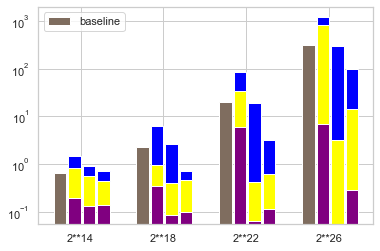

In [261]:
barWidth = 0.6
spacing = 0.1
numberOfInputSizes = len(df[df.function == 'np'])
baselineTicks = np.arange(numberOfInputSizes) * 4
npTicks = [x + barWidth + spacing for x in baselineTicks]
extTicks = [x + barWidth  +spacing for x in npTicks]
par24Ticks = [x + barWidth + spacing for x in extTicks]
comm = 'purple'
comp = 'yellow'
quant = 'blue'
def part3plot(ax, ticks, df, label):
    ax.bar(ticks, df.communication, width=barWidth, color=comm)
    ax.bar(ticks, df.computation, width=barWidth, color=comp, bottom=np.array(df.communication))
    ax.bar(ticks, df.quantization, width=barWidth, color=quant, bottom=np.array(df.computation))
#baseline
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.bar(baselineTicks, df[df['function'] == 'baseline'].total, width=barWidth, edgecolor='white', label='baseline', color='#7f6d5f')
#numpy
npy = df[df['function'] == 'np']
part3plot(ax, npTicks, npy, 'numpy')
ext = df[df['function'] == 'ext']
part3plot(ax, extTicks, ext, 'extension')
par24 = df[df['function'] == 'par24']
part3plot(ax, par24Ticks, par24, 'parallel')
plt.xticks(baselineTicks+1.5*barWidth + spacing, ('2**14', '2**18', '2**22', '2**26'))
plt.legend()
#ax.bar(extTicks, ext.communication, width=barWidth, color=comm)
#ax.bar(extTicks, ext.computation, width=barWidth, color=comp, bottom=ext.communication)
#ax.bar(extTicks, ext.quantization, width=barWidth, color=quant)

[  0.         822.08581731   3.18515046  14.34460753 515.53962803]


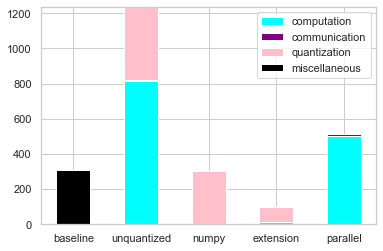

In [263]:
d2 = df[df['input_size'] == 26]
print(np.array(d2.communication+d2.computation))
x = np.arange(5)
width = 0.5
plt.bar(x, (d2.computation), width=width, color='cyan')
plt.bar(x, (d2.communication), bottom=np.array(d2.computation), width=width, color='purple')
plt.bar(x, (d2.quantization), bottom=np.array(d2.communication+d2.computation), width=width, color='pink')
plt.bar(x, d2.total-d2.computation-d2.communication-d2.quantization, bottom=np.array(d2.quantization+d2.communication+d2.computation), width=width, color='black')
plt.xticks(x, ['baseline', 'unquantized', 'numpy', 'extension', 'parallel'])
plt.legend(['computation', 'communication', 'quantization', 'miscellaneous'])
plt.savefig('26.png', dpi=300)

## Benchmarking of parallel quantize extension (v1)
Benchmarked by quantizing and unquantizing a tensor of 1 mio elements for 10k shots.
```python
def benchmarkQ(iters):
    quantize, unquantize = quantizy('ext_par')
    tensor = torch.one(2**20)
    
    for numberOfThreads in [1, 2, 4, 8, 16, 24, 32, 48]:
        start = time.time()
        for _ in range(iters):
            unquantize(quantize(tensor, numberOfThreads), numberOfThreads)
        runtime = time.time() - start
        print('{}: {}'.format(numberOfThreads, runtime))
```

In [ ]:
data = {
    1: 33.79728627204895,
    2: 36.45126271247864,
    4: 30.421996116638184,
    8: 23.117279529571533,
    16: 14.099677801132202,
    24: 2.432234048843384,
    32: 16.60316228866577,
    48: 86.07797956466675
}
numberOfThreads = list(data)
runtimes = list(data.values())
df = pd.DataFrame.from_dict({'numberOfThreads': numberOfThreads, 'runtimes': runtimes})
#sns.set(style="whitegrid")
#ax = sns.barplot(x='numberOfThreads', y='runtimes', data=df)
#ax.get_figure().savefig('ext_par_barplot.png')
fig = px.bar(df, x='numberOfThreads', y='runtimes')
fig.show()

In [ ]:
pd.DataFrame.from_dict({
    'function': ['all-reduce-unquantized']*4+['all-reduce-np']*4+['all-reduce-c++']*4+['all-reduce-c++--t4']*4+['all-reduce-c++--t24']*4,
    'input_sizes': [14, 18, 22, 26]*5,
    'runtimes': [2.8797550201416016, 3.628589153289795, 34.27912616729736, 586.1691422462463,
                5.380201578140259, 11.700040578842163, 105.51217818260193, 1355.664867401123,
                3.988344192504883, 7.569454193115234, 90.7022819519043, 1620.5233752727509,
                3.2412919998168945, 20.209644079208374, 51.957091093063354, 692.5020751953125,
                1.902247667312622, 2.1534981727600098, 8.664215326309204, 269.09099531173706],
    'communication': [0]*20,
    'quantization': [0]*20,
})